In [1]:
import mnist_reader
import numpy as np
import random
import math
import pickle
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the test and train datasets.
x_train = np.array(mnist_reader.x_train)
x_test = np.array(mnist_reader.x_test)
y_train = np.array(mnist_reader.y_train)
y_test = np.array(mnist_reader.y_test)

In [3]:
# Reshaping to make the images of 28*28 size into a feature vector of size 784.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

Parts 1, 2 and 3

In [4]:
class NeuralNetwork():
    def __init__(self, N, hidden_layer_sizes, lr, activation_fn, weight_init_fn, n_epochs, batch_size, early_stopping = False):
        # Error Handling
        if not isinstance(N, (int)):
            raise TypeError(f"No. of layers must be an integer. Instead received {type(N).__name__}.")
        if not isinstance(hidden_layer_sizes, (list)):
            raise TypeError(f"Hidden Layers have to be put in a list, not in a {type(hidden_layer_sizes).__name__}.")
        if not isinstance(lr, (int, float)):
            raise TypeError(f"Learning Rate must be a number. Instead received {type(N).__name__}.")
        if not isinstance(activation_fn, (str)):
            raise TypeError(f"Activation Function must be a string. Instead received {type(N).__name__}.")
        if not isinstance(weight_init_fn, (str)):
            raise TypeError(f"Weight Initialization Function must be a string. Instead received {type(N).__name__}.")
        if not isinstance(n_epochs, (int)):
            raise TypeError(f"No. of Epochs can only be an integer. Received instead {type(n_epochs).__name__}")
        if not isinstance(batch_size, (int)):
            raise TypeError(f"Batch size can only be an integer. Received instead {type(n_epochs).__name__}")
        if not isinstance(early_stopping, (bool)):
            raise TypeError(f"Early Stopping only accepts a boolean value. Instead received {type(early_stopping).__name__}.")

        if N <= 0:
            raise ValueError("No. of layers must be a positive number.")
        if lr < 0:
            raise ValueError("Learning Rate can't be negative!")
        if activation_fn not in ["sigmoid", "tanh", "relu", "leaky_relu"]:
            raise ValueError("Incorrect activation function. Activation function can only be from the following: sigmoid, tanh, relu, leaky_relu!")
        if weight_init_fn not in ["zero_init", "random_init", "normal_init"]:
            raise ValueError("Incorrect weight initialization function. It can only be from the following: zero_init, random_init, and normal_init!")
        if n_epochs <= 0:
            raise ValueError("No. of epochs has to be positive.")
        if batch_size <= 0:
            raise ValueError("Batch Size has to be positive!")
        
        self.N = N
        self.hidden_layer_sizes = hidden_layer_sizes
        self.lr = lr
        self.activation_fn = activation_fn
        self.weight_init_fn = weight_init_fn
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        self.input_dim = 1 # Will be set later when we fit the data.
        self.has_fit = False # Indicates whether a fit has already been made or not.
        self.list_weights = [] # List of weights at each layer.
        self.list_biases = [] # List of biases after each layer.
        self.n_classes = 0 # No. of labels
        self.val_update_stage = 0 # Denotes the last occasion when the val loss improved.
        self.val_losses = [] # Array to store the validation losses per epoch
        self.train_losses = [] # Array to store the training losses per epoch
        self.best_val_loss = float('inf') # Best val loss seen so far during training.
        self.last_loss = float('inf') # last Val loss seen
        self.best_weights = []
        self.best_biases = []

        if self.lr > 0.001:
            self.n_iters_after_val_incr = 5
        else:
            self.n_iters_after_val_incr = 5

        random.seed(42)

    # Assuming that if it is called twice, on the second time, it will improve the pre-existing model, not start afresh.
    def fit(self, X, Y):
        if not self.has_fit:
            self.n_classes = len(np.unique(Y))
            self.init_weight(np.shape(X)[1])
            self.has_fit = True

        # Splitting X and Y into train and val into a 8:1 train:val ratio as mentioned in the question.
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 1/9, random_state = 42)
        self.train(X_train, Y_train, X_val, Y_val)

    def predict(self, X):
        if not self.has_fit:
            print("Model not trained yet.")
            return
        
        list_probs = self.return_probabilities(X, training = False)

        min_prob = 0
        curr_class = 0
        for i in range(self.n_classes):
            if list_probs[0, i] > min_prob:
                min_prob = list_probs[0, i]
                curr_class = i

        print(f"It belongs to class {curr_class}.")

        return curr_class
    
    def predict_proba(self, X):
        if not self.has_fit:
            print("Model not trained yet.")
            return
        
        data_point = X.copy()

        for k in range(self.N):
            data_point = np.dot(data_point, self.best_weights[k]) + self.best_biases[k]
            data_point = self.activate(data_point) # Putting the activation.

        data_point = np.dot(data_point, self.best_weights[self.N]) + self.best_biases[self.N]
        data_point = self.activate(data_point, softmax = True)

        for i in range(self.n_classes):
            print(f"Probability for Class {i} -> {data_point[0, i]}")

    def score(self, X, Y):
        if not self.has_fit:
            print("Model not trained yet.")
            return
        
        n_samples = np.shape(X)[0]
        n_correct = 0
        for i in range(n_samples):
            y_pred = self.predict_internal(X[i:i+1, :])
            if y_pred == Y[i]:
                n_correct += 1

        accuracy = round((n_correct / n_samples) * 100, 2)
        print(f"The accuracy is {accuracy}%.")

        return accuracy

    # Function that returns the array of probabilities for being each class for a datapoint.
    def return_probabilities(self, X, training = True):
        data_point = X.copy()

        if training:
            for k in range(self.N):
                data_point = np.dot(data_point, self.list_weights[k]) + self.list_biases[k]
                data_point = self.activate(data_point) # Putting the activation.

            data_point = np.dot(data_point, self.list_weights[self.N]) + self.list_biases[self.N]
            data_point = self.activate(data_point, softmax = True)
        else:
            for k in range(self.N):
                data_point = np.dot(data_point, self.best_weights[k]) + self.best_biases[k]
                data_point = self.activate(data_point) # Putting the activation.

            data_point = np.dot(data_point, self.best_weights[self.N]) + self.best_biases[self.N]
            data_point = self.activate(data_point, softmax = True)

        return data_point
    
    def predict_internal(self, X):
        if not self.has_fit:
            print("Model not trained yet.")
            return
        
        list_probs = self.return_probabilities(X, training=False)

        min_prob = 0
        curr_class = 0
        for i in range(self.n_classes):
            if list_probs[0, i] > min_prob:
                min_prob = list_probs[0, i]
                curr_class = i

        return curr_class

    # Trains the model based on the given X and Y.
    def train(self, X, Y, X_Val, Y_Val):
        # Making temporary bias and weight matrices for use later on.
        tmp_bias_arr = []
        tmp_weight_arr = []
        for i in self.list_weights:
            tmp_weight_arr.append(np.zeros(np.shape(i)))
        for i in self.list_biases:
            tmp_bias_arr.append(np.zeros(np.shape(i)))

        for iter_no in range(self.n_epochs):
            n_samples = np.shape(X)[0]

            n_batch = math.ceil(n_samples / self.batch_size)
            for i in range(n_batch):
                # Finding indices of first and last_samples in batch.
                init_sample = self.batch_size*i
                last_sample = min(self.batch_size*(i+1), n_samples) - 1
                data_samples = X[init_sample:last_sample+1, :].copy() 

                # Making an array of intermediary results that stores the activated values at each layer.
                intermed_arr = []
                intermed_arr.append(data_samples.copy())

                # Finding activations after each layer.
                for k in range(self.N):
                    data_samples = np.dot(data_samples, self.list_weights[k]) + self.list_biases[k]
                    data_samples = self.activate(data_samples) # Putting the activation.
                    intermed_arr.append(data_samples.copy())

                data_samples = np.dot(data_samples, self.list_weights[self.N]) + self.list_biases[self.N]

                data_samples = self.activate(data_samples, softmax = True)

                # Perform the backward Pass.
                self.backward_pass(data_samples, tmp_weight_arr, tmp_bias_arr, intermed_arr, Y[init_sample:last_sample+1])

                # Clearing the temporary arrays.
                intermed_arr.clear()
                del intermed_arr
                
                batchsize = last_sample - init_sample + 1
                tmp_weight_arr = [matrix / batchsize for matrix in tmp_weight_arr] # Finding average gradient for each weight by dividing by batchsize.
                tmp_bias_arr = [arr / batchsize for arr in tmp_bias_arr]

                # Updating the weights.
                for j in range(len(self.list_weights)):
                    self.list_weights[j] = self.list_weights[j] - self.lr * tmp_weight_arr[j]
                    self.list_biases[j] = self.list_biases[j] - self.lr * tmp_bias_arr[j]

                # Resetting the temporary arrays to fill them with zeroes again.
                for j in tmp_weight_arr:
                    j.fill(0)
                
                for j in tmp_bias_arr:
                    j.fill(0)

            n_val_samples = np.shape(X_Val)[0]

            # Train Loss
            Train_Prob_matrix = self.return_probabilities(X)  # Finding probabilities of each datapoint in train set.
            train_loss = -np.sum(np.log(Train_Prob_matrix[np.arange(n_samples), Y])) / n_samples  # Loss is cross-entropy so -ve of log of the probability of the correct class appearing.

            # Val Loss
            Val_Prob_matrix = self.return_probabilities(X_Val)
            val_loss = -np.sum(np.log(Val_Prob_matrix[np.arange(n_val_samples), Y_Val])) / n_val_samples

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"Epoch {iter_no + 1} -> Val Loss: {val_loss}, Training Loss: {train_loss}.")

            # Implementing early stopping.
            if self.early_stopping == True:
                if iter_no == 0:
                    continue
                else:
                    if self.val_update_stage == self.n_iters_after_val_incr:
                        print(f"Early Stopping! Val Loss hasn't improved in the last {self.n_iters_after_val_incr} iterations!")
                        break

                    if val_loss < self.best_val_loss:
                        self.best_val_loss = val_loss
                        self.best_weights = copy.deepcopy(self.list_weights)
                        self.best_biases = copy.deepcopy(self.list_biases)

                    if val_loss > self.last_loss:
                        self.val_update_stage += 1
                        self.last_loss = val_loss
                    else:
                        self.val_update_stage = 0
                        self.last_loss = val_loss

    # Performs the backward pass on a given "input", and adds the resultant gradient for each weight to the 'res_weights' object.
    def backward_pass(self, input, res_weights, res_bias, intermed_vals, y_actual):
        list_dims = self.hidden_layer_sizes + [self.n_classes] # List of all the dimensions
        local_grad = [np.zeros((dim, input.shape[0])) for dim in list_dims] # List to store all the local gradients at each stage.

        # First, update weights attached to output layer.
        shape_wght = np.shape(self.list_weights[self.N])

        condition_matrix = (y_actual[:, None] == np.arange(shape_wght[1])).astype(int) # If y_actual == i, it is 1, else 0.
        local_gradient = input - condition_matrix  # Gradient achieved after differentiating loss function of softmax wrt pre-activated input.
        local_grad[self.N] = local_gradient.T

        res_weights[self.N] += np.dot(local_gradient.T, intermed_vals[self.N]).T  #  Local Gradient * y_i
        res_bias[self.N] += np.sum(local_gradient, axis=0, keepdims=True)  # Bias where we are effectively just doing a dot product with a column vector of 1s (or sum).

        # Updating the other weights.
        for layer in range(self.N - 1, -1, -1):
            shape_wght = np.shape(self.list_weights[layer])
            next_layer_weights = self.list_weights[layer + 1]  # Weights for Next Layer.
            activated_matrix = self.activation_gradient(intermed_vals[layer + 1]) # Differentiation of activation function to be used later.

            local_grad[layer] = (np.dot(next_layer_weights, local_grad[layer + 1])) * activated_matrix.T

            # Updation of Weights.
            res_weights[layer] += np.dot(local_grad[layer], intermed_vals[layer]).T
            res_bias[layer] += np.sum(local_grad[layer], axis=1, keepdims=True).T # Bias

        # Clearing the temporary arrays.
        local_grad.clear()
        del local_grad

    # Initializes the weights and biases based on the weight init function -> Part 3.
    def init_weight(self, first_dim):
        random.seed(42)
        
        list_dims = []
        list_dims.append(first_dim)
        for i in self.hidden_layer_sizes:
            list_dims.append(i)
        list_dims.append(self.n_classes)

        for i in range(len(list_dims) - 1):
            # Initializing with zeros.
            weight_matrix = np.zeros((list_dims[i], list_dims[i+1]))
            bias_arr = np.zeros((1, list_dims[i+1]))

            if self.weight_init_fn == 'zero_init':
                self.list_biases.append(bias_arr)
                self.list_weights.append(weight_matrix)

            # Randomly initializing weights. I am setting them between -0.1 and 0.1 to not keep them too large and close to 0.
            elif self.weight_init_fn == 'random_init':
                for j in range(list_dims[i]):
                    for k in range(list_dims[i+1]):
                        weight_matrix[j, k] = -0.1 + 0.2 * random.random() # Keeps it between -0.1 and 0.1.

                for j in range(list_dims[i+1]):
                    bias_arr[0, j] = -0.1 + 0.2 * random.random()

                self.list_biases.append(bias_arr)
                self.list_weights.append(weight_matrix)

            # Initializing weights by sampling from the normal distribution. Here instead of a std dev of 1, I am setting it to 0.1, as otherwise
            # the values will explode in the forward pass and there will be NaNs. As the question mentioned scaling factors are allowed, i presume
            # this is their interpretation of scaling.
            elif self.weight_init_fn == 'normal_init':
                for j in range(list_dims[i]):
                    for k in range(list_dims[i+1]):
                        weight_matrix[j, k] = random.gauss(0, 0.1)

                for j in range(list_dims[i+1]):
                    bias_arr[0, j] = random.gauss(0, 0.1)

                self.list_biases.append(bias_arr)
                self.list_weights.append(weight_matrix)

        self.best_biases = copy.deepcopy(self.list_biases)
        self.best_weights = copy.deepcopy(self.list_weights)

    # Function for passing an input through the activation function to get an output. -> Part 2
    def activate(self, input, softmax = False):
        if softmax == True:
            # if self.weight_init_fn == 'normal_init': # Stable softmax to reduce the explosion of the gradient due to normal initialization.
            #     input_mod = input - np.max(input, axis=1, keepdims=True)
            #     tmp = np.exp(input_mod)
            #     return tmp / np.sum(tmp, axis=1, keepdims=True)
            
            tmp = np.exp(input)
            sums_arr = np.sum(tmp, axis=1, keepdims=True)
            return tmp / sums_arr # Softmax is basically e^ai / (e^a1 + e^a2 + ... + e^an) where n is the number of classes.
            
        else:
            if self.activation_fn == 'sigmoid':
                return 1 / (1 + np.exp(-input)) # Sigmoid is 1 / (1 + e^(-x))
            
            elif self.activation_fn == 'tanh':
                return (np.exp(input) - np.exp(-input)) / (np.exp(input) + np.exp(-input)) # Tanh is (e^x - e^-x) / (e^x + e^-x)

            elif self.activation_fn == 'relu':
                return np.maximum(input, 0) # ReLU is max(0, x)
            
            # Using coefficient of 0.01 for leaky_RELU
            else:
                return np.where(input > 0, input, 0.01 * input) # Leaky_ReLU is x if x > 0 and alpha * x if x <= 0
    
    # Function to find gradients of each activation function. For softmax, pred_bool is when the corresponding softmax node is the 
    # correct prediction or not, and softmax_sum is the sum of all the e^a_is.
    def activation_gradient(self, input, softmax = False, softmax_sum = 0, pred_bool = False):
        if softmax == True:
            if pred_bool == True:
                tmp = 1
            else:
                tmp = 0
            return (np.exp(input) / softmax_sum) - tmp
        
        else:
            if self.activation_fn == 'sigmoid':
                sigmoid = 1 / (1 + np.exp(-input))
                return sigmoid * (1 - sigmoid) # The derivative of sigmoid = sigmoid * (1-sigmoid)
            
            elif self.activation_fn == 'tanh':
                tanh = (np.exp(input) - np.exp(-input)) / (np.exp(input) + np.exp(-input))
                return 1 - tanh**2 # Derivative of tanh is sech^2x which is 1 - tanh^2x

            elif self.activation_fn == 'relu':
                return np.where(input > 0, 1, 0) # Differentiating x gives 1, and differentiating 0 with respect to x gives 0.
            
            # Using coefficient of 0.01 for leaky_RELU
            else:
                return np.where(input > 0, 1, 0.01) # Differentiating x gives 1. Differentiating alpha*x gives alpha.

In [5]:
# Preparing the Train and Test Data

random.seed(42) # Seed to maintain consistency in results.

train_indices = np.random.choice(x_train.shape[0], size=36000, replace=False)
X_train = x_train[train_indices]
Y_train = y_train[train_indices]

test_indices = np.random.choice(x_test.shape[0], size=4000, replace=False)
X_test = x_test[test_indices]
Y_test = y_test[test_indices]

Part 4

In [6]:
# Normalizing X_train and test by dividing by 255 - PREPROCESSING
X_train = X_train / 255
X_test = X_test / 255

In [192]:
# RELU and Random init.
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='relu',weight_init_fn='random_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

Epoch 1 -> Val Loss: 0.9571304139172366, Training Loss: 0.9391523136055998.
Epoch 2 -> Val Loss: 0.3542818077566884, Training Loss: 0.34705084073776366.
Epoch 3 -> Val Loss: 0.22789209215151987, Training Loss: 0.2104324756500844.
Epoch 4 -> Val Loss: 0.1772332438983404, Training Loss: 0.15072061379549437.
Epoch 5 -> Val Loss: 0.15425262787891, Training Loss: 0.11801913317491598.
Epoch 6 -> Val Loss: 0.13864742478279363, Training Loss: 0.09424979309119416.
Epoch 7 -> Val Loss: 0.12982188900575153, Training Loss: 0.07669097171913192.
Epoch 8 -> Val Loss: 0.12427054514318547, Training Loss: 0.060795743939194.
Epoch 9 -> Val Loss: 0.12278716404456665, Training Loss: 0.05037032826676879.
Epoch 10 -> Val Loss: 0.12333183349578745, Training Loss: 0.042094739531387.
Epoch 11 -> Val Loss: 0.12698471590119617, Training Loss: 0.0352326090157877.
Epoch 12 -> Val Loss: 0.13101594845342454, Training Loss: 0.03153844365873667.
Epoch 13 -> Val Loss: 0.12978183026885162, Training Loss: 0.02424348856185

In [193]:
accuracy_dict = {} # For storing the accuracies for each activation function and weight init combo

In [194]:
accuracy_dict['Relu_Random'] = model.score(X_test, Y_test)

The accuracy is 97.12%.


In [195]:
with open('Relu_Random.pkl', 'wb') as file:
    pickle.dump(model, file)

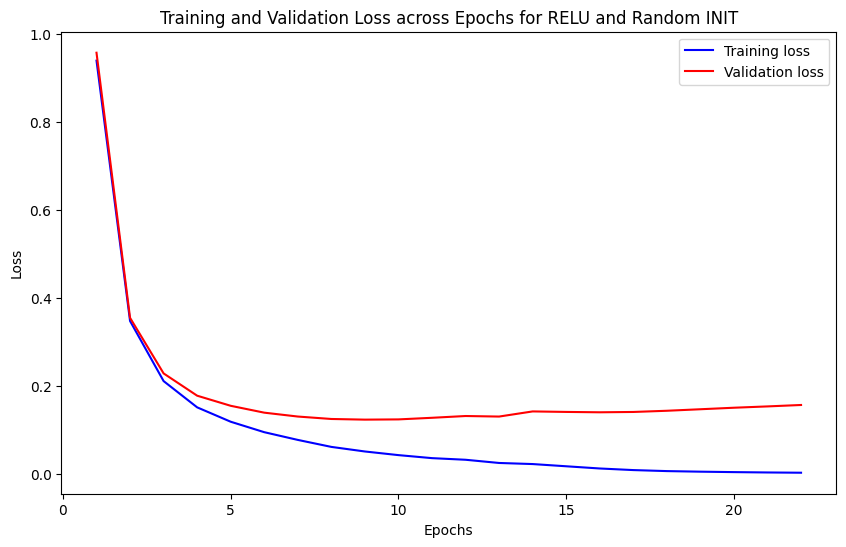

In [196]:
n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for RELU and Random INIT')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.3019084438465254, Training Loss: 2.3013250249414474.
Epoch 2 -> Val Loss: 2.301935534798352, Training Loss: 2.3013149801026294.
Epoch 3 -> Val Loss: 2.301937424492252, Training Loss: 2.301314768169743.
Epoch 4 -> Val Loss: 2.3019375117881062, Training Loss: 2.301314757099998.
Epoch 5 -> Val Loss: 2.301937513064773, Training Loss: 2.3013147562950307.
Epoch 6 -> Val Loss: 2.301937512662107, Training Loss: 2.3013147562250755.
Epoch 7 -> Val Loss: 2.3019375125840726, Training Loss: 2.3013147562181957.
Epoch 8 -> Val Loss: 2.3019375125735757, Training Loss: 2.3013147562174727.
Epoch 9 -> Val Loss: 2.3019375125723336, Training Loss: 2.3013147562173946.
Epoch 10 -> Val Loss: 2.3019375125721964, Training Loss: 2.301314756217386.
Epoch 11 -> Val Loss: 2.3019375125721813, Training Loss: 2.3013147562173852.
Epoch 12 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 13 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 14 -> Val Los

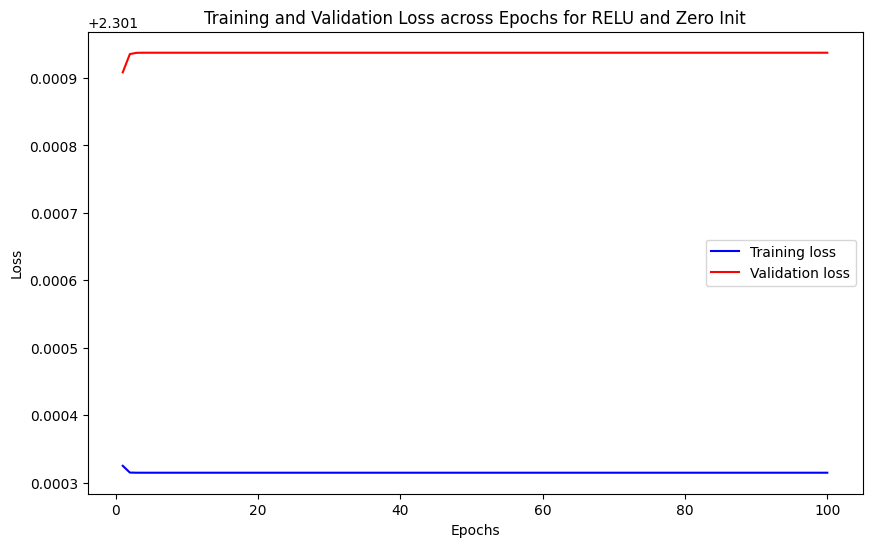

In [197]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='relu',weight_init_fn='zero_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Relu_Zero'] = model.score(X_test, Y_test)

with open('Relu_Zero.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for RELU and Zero Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 0.31709308609211856, Training Loss: 0.3106429034057312.
Epoch 2 -> Val Loss: 0.2174880343079474, Training Loss: 0.19664746213174855.
Epoch 3 -> Val Loss: 0.17684393690654, Training Loss: 0.14564702327093199.
Epoch 4 -> Val Loss: 0.15078642428813502, Training Loss: 0.11092803649719161.
Epoch 5 -> Val Loss: 0.1377178306666872, Training Loss: 0.0890464035320347.
Epoch 6 -> Val Loss: 0.12991404413546667, Training Loss: 0.07220067524457782.
Epoch 7 -> Val Loss: 0.1266285309485181, Training Loss: 0.059488330197322054.
Epoch 8 -> Val Loss: 0.12478759424887083, Training Loss: 0.048367335241887924.
Epoch 9 -> Val Loss: 0.12393809786464613, Training Loss: 0.039114949751875815.
Epoch 10 -> Val Loss: 0.12281003018562937, Training Loss: 0.030751462064146275.
Epoch 11 -> Val Loss: 0.12323442684852728, Training Loss: 0.023862430384842842.
Epoch 12 -> Val Loss: 0.12453043513728926, Training Loss: 0.018695947447415852.
Epoch 13 -> Val Loss: 0.12658327609708664, Training Loss: 0.014

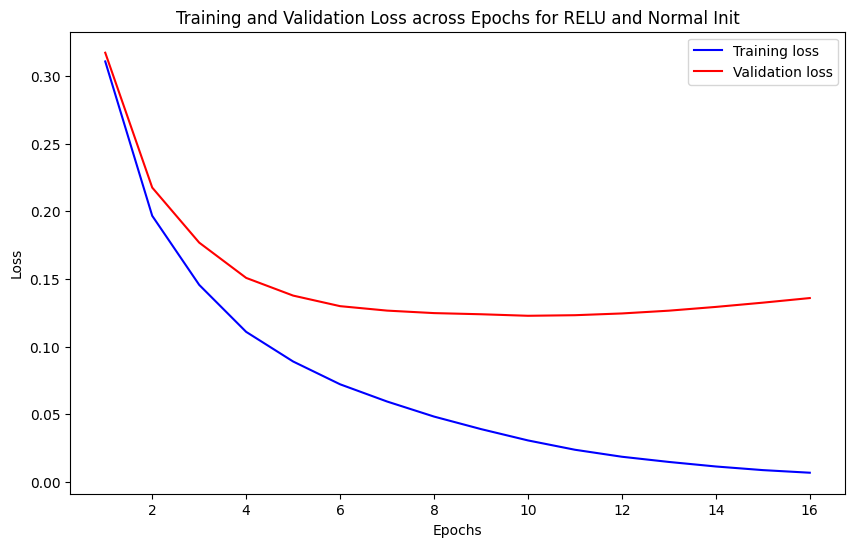

In [198]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='relu',weight_init_fn='normal_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Relu_Normal'] = model.score(X_test, Y_test)

with open('Relu_Normal.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for RELU and Normal Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.30167671991007, Training Loss: 2.301789435107743.
Epoch 2 -> Val Loss: 2.301653179598189, Training Loss: 2.301772475974117.
Epoch 3 -> Val Loss: 2.3016300282679336, Training Loss: 2.3017554423041293.
Epoch 4 -> Val Loss: 2.3016071858625726, Training Loss: 2.301738258654203.
Epoch 5 -> Val Loss: 2.301584569784404, Training Loss: 2.3017208473615303.
Epoch 6 -> Val Loss: 2.301562093966786, Training Loss: 2.3017031276080493.
Epoch 7 -> Val Loss: 2.3015396678269027, Training Loss: 2.3016850143650145.
Epoch 8 -> Val Loss: 2.301517195063981, Training Loss: 2.301666417183383.
Epoch 9 -> Val Loss: 2.3014945722602334, Training Loss: 2.301647238787452.
Epoch 10 -> Val Loss: 2.3014716872308565, Training Loss: 2.3016273734183494.
Epoch 11 -> Val Loss: 2.301448417054816, Training Loss: 2.301606704859464.
Epoch 12 -> Val Loss: 2.3014246256985356, Training Loss: 2.301585104056445.
Epoch 13 -> Val Loss: 2.301400161118171, Training Loss: 2.301562426218153.
Epoch 14 -> Val Loss: 2.

C:\Users\Abhirup Das\AppData\Local\Temp\ipykernel_38224\1274100114.py:349: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-input)) # Sigmoid is 1 / (1 + e^(-x))


Epoch 53 -> Val Loss: 2.0703482866147387, Training Loss: 2.06894519247967.
Epoch 54 -> Val Loss: 2.068043698307146, Training Loss: 2.0679215582037367.
Epoch 55 -> Val Loss: 2.0667683602207174, Training Loss: 2.0670644245264236.
Epoch 56 -> Val Loss: 2.066127002068587, Training Loss: 2.0658256569916595.
Epoch 57 -> Val Loss: 2.0646529107157714, Training Loss: 2.0650496055260903.
Epoch 58 -> Val Loss: 2.063673633372184, Training Loss: 2.0641850956932433.
Epoch 59 -> Val Loss: 2.062622895364521, Training Loss: 2.06346872477982.
Epoch 60 -> Val Loss: 2.062100125774301, Training Loss: 2.062796698663182.
Epoch 61 -> Val Loss: 2.061698039818984, Training Loss: 2.062324348484669.
Epoch 62 -> Val Loss: 2.060692573281078, Training Loss: 2.06201990532593.
Epoch 63 -> Val Loss: 2.05976273567952, Training Loss: 2.061509600707807.
Epoch 64 -> Val Loss: 2.05965341147699, Training Loss: 2.061156413739304.
Epoch 65 -> Val Loss: 2.0592058541775695, Training Loss: 2.0607512181288326.
Epoch 66 -> Val Loss

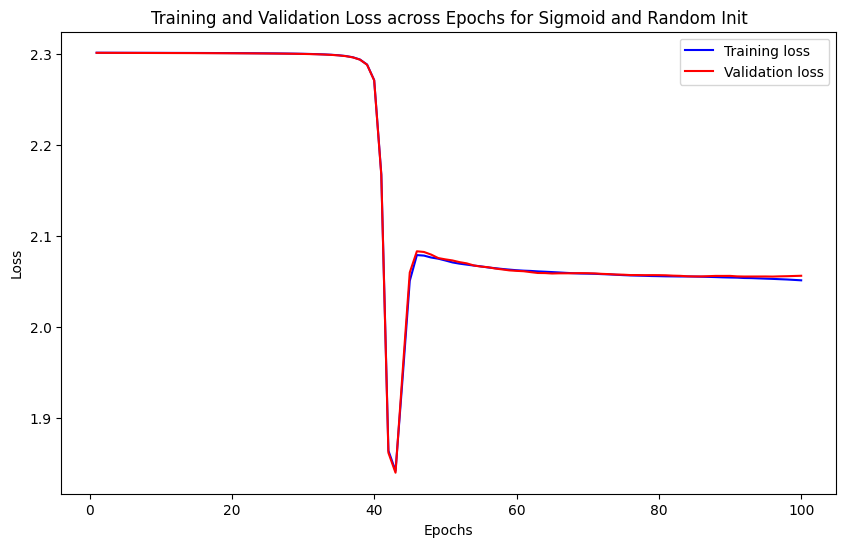

In [199]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='sigmoid',weight_init_fn='random_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Sigmoid_Random'] = model.score(X_test, Y_test)

with open('Sigmoid_Random.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Sigmoid and Random Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.3016880201627683, Training Loss: 2.3017967330029703.
Epoch 2 -> Val Loss: 2.3016794668078937, Training Loss: 2.301794404285759.
Epoch 3 -> Val Loss: 2.3016713779379416, Training Loss: 2.301792122497437.
Epoch 4 -> Val Loss: 2.301663738181659, Training Loss: 2.301789876975382.
Epoch 5 -> Val Loss: 2.301656532732721, Training Loss: 2.301787657784628.
Epoch 6 -> Val Loss: 2.301649747319898, Training Loss: 2.3017854556865487.
Epoch 7 -> Val Loss: 2.3016433681787674, Training Loss: 2.3017832621087844.
Epoch 8 -> Val Loss: 2.3016373820248717, Training Loss: 2.3017810691163896.
Epoch 9 -> Val Loss: 2.3016317760282847, Training Loss: 2.301778869384113.
Epoch 10 -> Val Loss: 2.3016265377895886, Training Loss: 2.3017766561697797.
Epoch 11 -> Val Loss: 2.301621655317217, Training Loss: 2.301774423288699.
Epoch 12 -> Val Loss: 2.301617117006144, Training Loss: 2.3017721650890652.
Epoch 13 -> Val Loss: 2.3016129116178883, Training Loss: 2.301769876428284.
Epoch 14 -> Val Loss

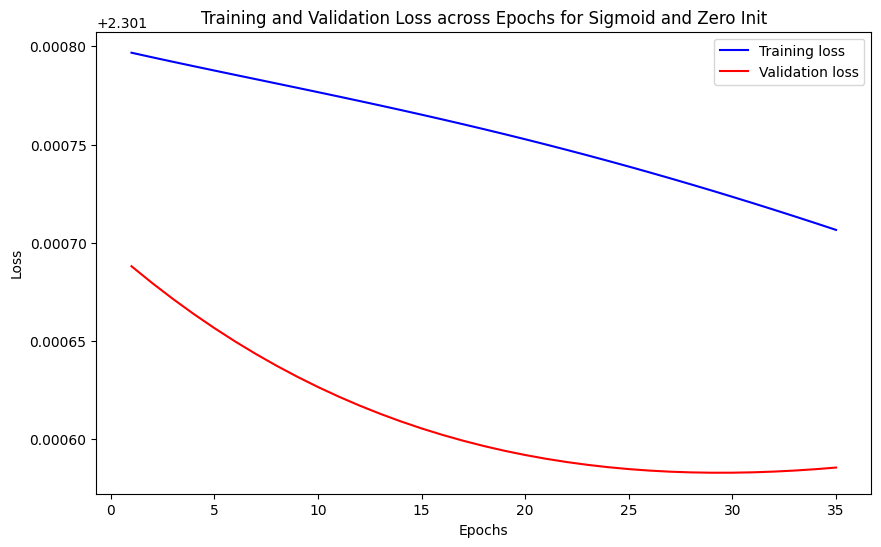

In [200]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='sigmoid',weight_init_fn='zero_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Sigmoid_Zero'] = model.score(X_test, Y_test)

with open('Sigmoid_Zero.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Sigmoid and Zero Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.3012540575000977, Training Loss: 2.3012745724758905.
Epoch 2 -> Val Loss: 2.3004658356106202, Training Loss: 2.300501855432023.
Epoch 3 -> Val Loss: 2.2995723934076437, Training Loss: 2.29962279977839.
Epoch 4 -> Val Loss: 2.298482095227878, Training Loss: 2.298546009127636.
Epoch 5 -> Val Loss: 2.2970469773115063, Training Loss: 2.2971237575862675.
Epoch 6 -> Val Loss: 2.2949942414803703, Training Loss: 2.295083551517765.
Epoch 7 -> Val Loss: 2.291745685458602, Training Loss: 2.29184768748409.
Epoch 8 -> Val Loss: 2.2858352346192317, Training Loss: 2.2859510996784937.
Epoch 9 -> Val Loss: 2.272385096542963, Training Loss: 2.272518708982777.
Epoch 10 -> Val Loss: 2.2251567268947534, Training Loss: 2.2253320977174273.
Epoch 11 -> Val Loss: 1.9297023659398533, Training Loss: 1.9312208373480613.
Epoch 12 -> Val Loss: 1.6413486168462337, Training Loss: 1.647529522868665.
Epoch 13 -> Val Loss: 1.4861817382212466, Training Loss: 1.4950300215037733.
Epoch 14 -> Val Loss

C:\Users\Abhirup Das\AppData\Local\Temp\ipykernel_38224\1274100114.py:349: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-input)) # Sigmoid is 1 / (1 + e^(-x))


Epoch 23 -> Val Loss: 1.297780478030635, Training Loss: 1.3014908242695338.
Epoch 24 -> Val Loss: 1.2946215078227696, Training Loss: 1.2933525792303908.
Epoch 25 -> Val Loss: 1.2983235401768296, Training Loss: 1.290469977975422.
Epoch 26 -> Val Loss: 1.2934398475302897, Training Loss: 1.2846072121983514.
Epoch 27 -> Val Loss: 1.273671983869618, Training Loss: 1.2673843507007418.
Epoch 28 -> Val Loss: 1.2482585790289369, Training Loss: 1.2436535894192913.
Epoch 29 -> Val Loss: 1.2120115703400085, Training Loss: 1.2119145345203015.
Epoch 30 -> Val Loss: 1.164552573401717, Training Loss: 1.1665140629288349.
Epoch 31 -> Val Loss: 1.0867043602099529, Training Loss: 1.091137780274403.
Epoch 32 -> Val Loss: 1.0217881444047077, Training Loss: 1.0193858354806886.
Epoch 33 -> Val Loss: 0.968853871829506, Training Loss: 0.97140123385529.
Epoch 34 -> Val Loss: 0.9376259170000064, Training Loss: 0.9425729569895593.
Epoch 35 -> Val Loss: 0.9167074499351167, Training Loss: 0.9204664565651017.
Epoch 3

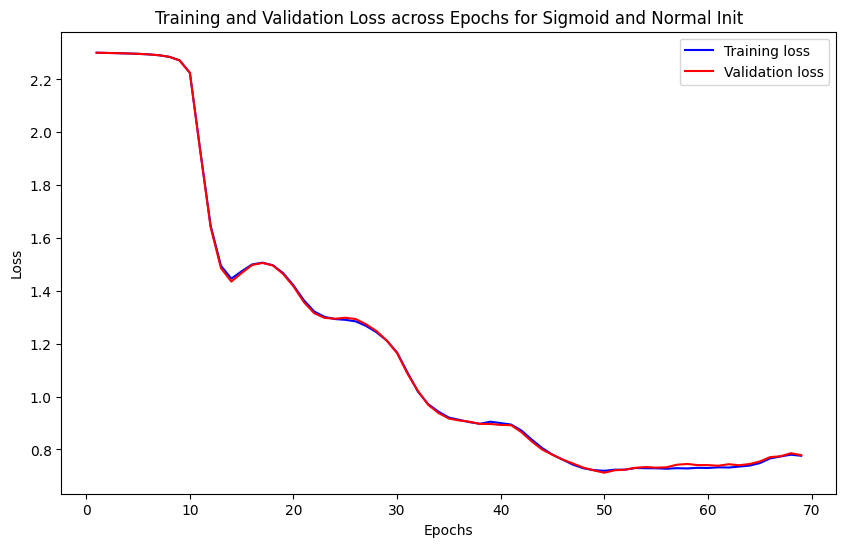

In [201]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='sigmoid',weight_init_fn='normal_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Sigmoid_Normal'] = model.score(X_test, Y_test)

with open('Sigmoid_Normal.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Sigmoid and Normal Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 0.5286913518170834, Training Loss: 0.5340648071002337.
Epoch 2 -> Val Loss: 0.32561011758582414, Training Loss: 0.32071726779976734.
Epoch 3 -> Val Loss: 0.272841357694084, Training Loss: 0.25525974002956314.
Epoch 4 -> Val Loss: 0.23417832638740366, Training Loss: 0.20655397368314007.
Epoch 5 -> Val Loss: 0.20356323741314977, Training Loss: 0.17037581994615314.
Epoch 6 -> Val Loss: 0.18486619528306605, Training Loss: 0.14672760416797337.
Epoch 7 -> Val Loss: 0.17369226514842925, Training Loss: 0.13053171746795264.
Epoch 8 -> Val Loss: 0.1661248607937776, Training Loss: 0.1176986842836683.
Epoch 9 -> Val Loss: 0.15494812211139244, Training Loss: 0.10217906425090402.
Epoch 10 -> Val Loss: 0.14650030000855094, Training Loss: 0.08959891039200389.
Epoch 11 -> Val Loss: 0.14339386260642775, Training Loss: 0.08134327779426424.
Epoch 12 -> Val Loss: 0.1398920417747297, Training Loss: 0.0730643341316492.
Epoch 13 -> Val Loss: 0.1454020225354824, Training Loss: 0.0915767634

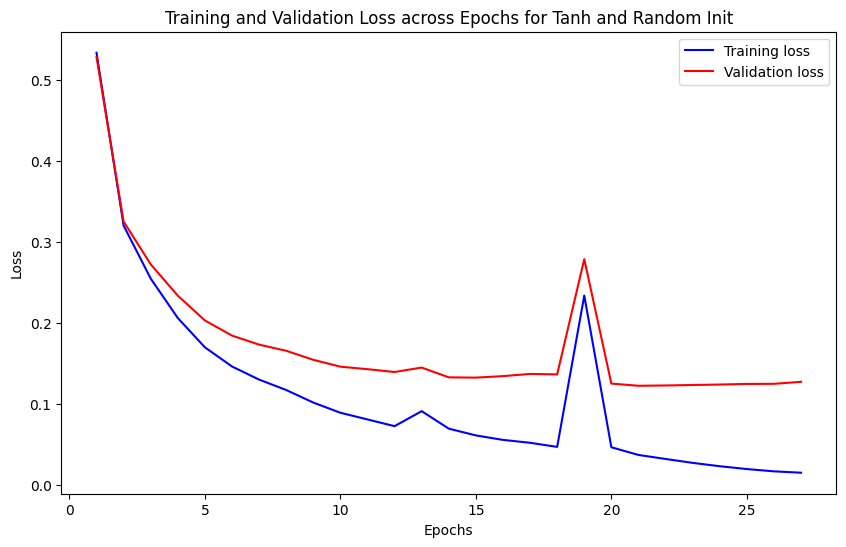

In [202]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='tanh',weight_init_fn='random_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Tanh_Random'] = model.score(X_test, Y_test)

with open('Tanh_Random.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Tanh and Random Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.3019084438465254, Training Loss: 2.3013250249414474.
Epoch 2 -> Val Loss: 2.301935534798352, Training Loss: 2.3013149801026294.
Epoch 3 -> Val Loss: 2.301937424492252, Training Loss: 2.301314768169743.
Epoch 4 -> Val Loss: 2.3019375117881062, Training Loss: 2.301314757099998.
Epoch 5 -> Val Loss: 2.301937513064773, Training Loss: 2.3013147562950307.
Epoch 6 -> Val Loss: 2.301937512662107, Training Loss: 2.3013147562250755.
Epoch 7 -> Val Loss: 2.3019375125840726, Training Loss: 2.3013147562181957.
Epoch 8 -> Val Loss: 2.3019375125735757, Training Loss: 2.3013147562174727.
Epoch 9 -> Val Loss: 2.3019375125723336, Training Loss: 2.3013147562173946.
Epoch 10 -> Val Loss: 2.3019375125721964, Training Loss: 2.301314756217386.
Epoch 11 -> Val Loss: 2.3019375125721813, Training Loss: 2.3013147562173852.
Epoch 12 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 13 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 14 -> Val Los

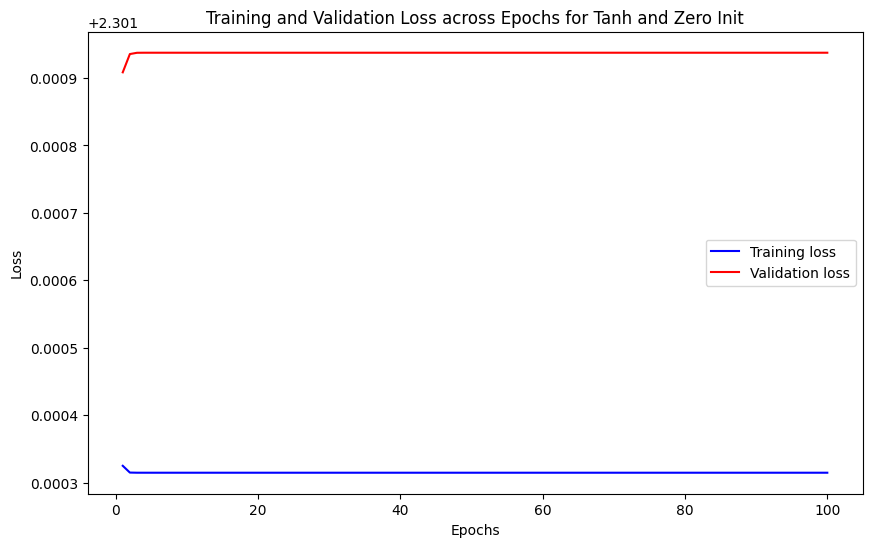

In [203]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='tanh',weight_init_fn='zero_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Tanh_Zero'] = model.score(X_test, Y_test)

with open('Tanh_Zero.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Tanh and Zero Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 0.3552224846326726, Training Loss: 0.35129424149230365.
Epoch 2 -> Val Loss: 0.2626891886985211, Training Loss: 0.24393807193398517.
Epoch 3 -> Val Loss: 0.222231343616949, Training Loss: 0.18972508842477412.
Epoch 4 -> Val Loss: 0.19509281819544638, Training Loss: 0.15262049670522992.
Epoch 5 -> Val Loss: 0.17628648783669357, Training Loss: 0.12590630707408174.
Epoch 6 -> Val Loss: 0.16229200360248514, Training Loss: 0.10466104867126036.
Epoch 7 -> Val Loss: 0.1531500732257664, Training Loss: 0.08824316486399779.
Epoch 8 -> Val Loss: 0.14940709920888404, Training Loss: 0.07671679015544132.
Epoch 9 -> Val Loss: 0.15001205795302405, Training Loss: 0.06903042767107333.
Epoch 10 -> Val Loss: 0.15336082733173745, Training Loss: 0.0641192838201711.
Epoch 11 -> Val Loss: 0.16311519920317544, Training Loss: 0.08888397704505814.
Epoch 12 -> Val Loss: 0.1407570447325489, Training Loss: 0.05702914333913691.
Epoch 13 -> Val Loss: 0.13817868026595886, Training Loss: 0.04486826

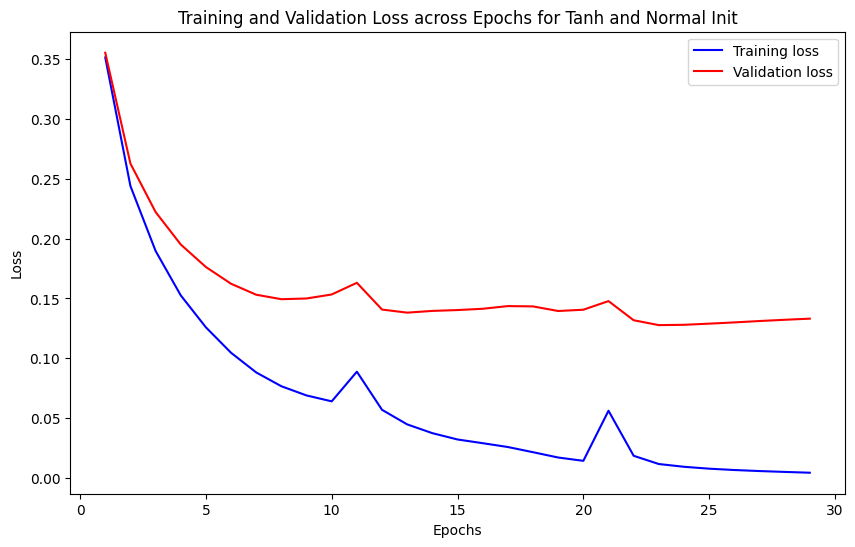

In [204]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='tanh',weight_init_fn='normal_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['Tanh_Normal'] = model.score(X_test, Y_test)

with open('Tanh_Normal.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Tanh and Normal Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 0.8439891237081656, Training Loss: 0.8296344267548144.
Epoch 2 -> Val Loss: 0.3536629781682696, Training Loss: 0.3457269428942593.
Epoch 3 -> Val Loss: 0.22763803765337806, Training Loss: 0.21038636440091127.
Epoch 4 -> Val Loss: 0.17632616923494482, Training Loss: 0.1505813639979603.
Epoch 5 -> Val Loss: 0.15237814931902427, Training Loss: 0.1174446344755373.
Epoch 6 -> Val Loss: 0.1381059691192034, Training Loss: 0.09345308825254739.
Epoch 7 -> Val Loss: 0.12991181449724828, Training Loss: 0.07639901087347445.
Epoch 8 -> Val Loss: 0.12672675017739862, Training Loss: 0.0627177086328532.
Epoch 9 -> Val Loss: 0.12376934918855702, Training Loss: 0.050997950215763366.
Epoch 10 -> Val Loss: 0.12420947100274114, Training Loss: 0.04262037380990778.
Epoch 11 -> Val Loss: 0.12710905731220418, Training Loss: 0.036316386886597184.
Epoch 12 -> Val Loss: 0.1314616357452458, Training Loss: 0.0316044512579563.
Epoch 13 -> Val Loss: 0.132947623735259, Training Loss: 0.02662256084

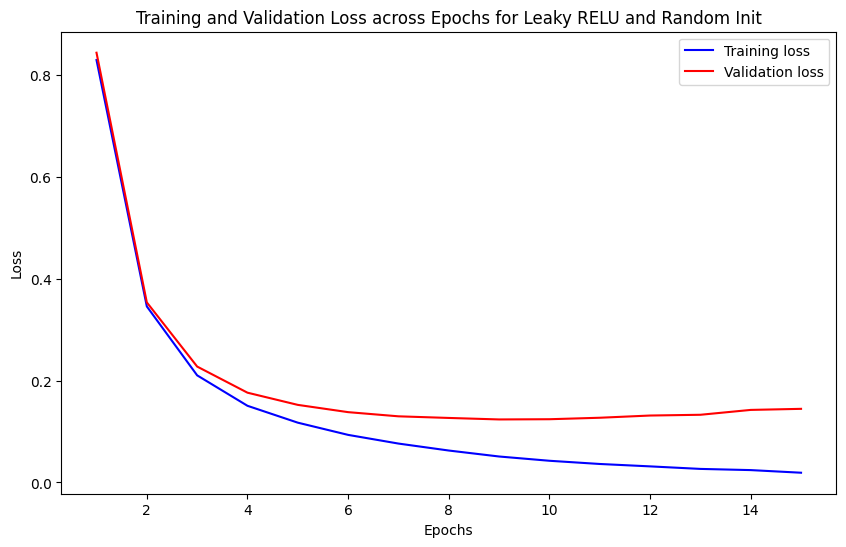

In [205]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='leaky_relu',weight_init_fn='random_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['LeakyRELU_Random'] = model.score(X_test, Y_test)

with open('LeakyRELU_Random.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Leaky RELU and Random Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 2.3019084438465254, Training Loss: 2.3013250249414474.
Epoch 2 -> Val Loss: 2.301935534798352, Training Loss: 2.3013149801026294.
Epoch 3 -> Val Loss: 2.301937424492252, Training Loss: 2.301314768169743.
Epoch 4 -> Val Loss: 2.3019375117881062, Training Loss: 2.301314757099998.
Epoch 5 -> Val Loss: 2.301937513064773, Training Loss: 2.3013147562950307.
Epoch 6 -> Val Loss: 2.301937512662107, Training Loss: 2.3013147562250755.
Epoch 7 -> Val Loss: 2.3019375125840726, Training Loss: 2.3013147562181957.
Epoch 8 -> Val Loss: 2.3019375125735757, Training Loss: 2.3013147562174727.
Epoch 9 -> Val Loss: 2.3019375125723336, Training Loss: 2.3013147562173946.
Epoch 10 -> Val Loss: 2.3019375125721964, Training Loss: 2.301314756217386.
Epoch 11 -> Val Loss: 2.3019375125721813, Training Loss: 2.3013147562173852.
Epoch 12 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 13 -> Val Loss: 2.30193751257218, Training Loss: 2.3013147562173852.
Epoch 14 -> Val Los

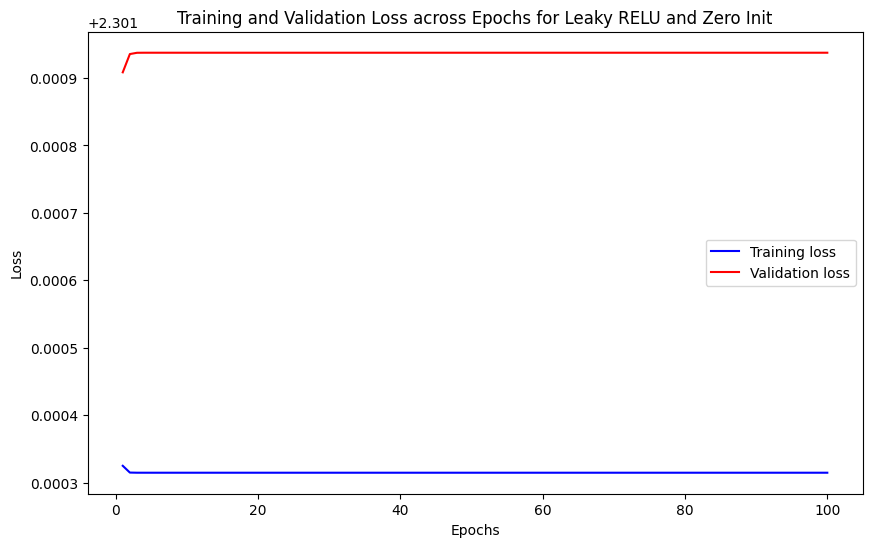

In [206]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='leaky_relu',weight_init_fn='zero_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['LeakyRELU_Zero'] = model.score(X_test, Y_test)

with open('LeakyRELU_Zero.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Leaky RELU and Zero Init')
plt.legend()

plt.show()

Epoch 1 -> Val Loss: 0.3183014990361862, Training Loss: 0.3122141472918477.
Epoch 2 -> Val Loss: 0.21772377284899874, Training Loss: 0.19760497733433238.
Epoch 3 -> Val Loss: 0.17786624529326847, Training Loss: 0.1478224779137629.
Epoch 4 -> Val Loss: 0.1508267157051147, Training Loss: 0.11185038525562727.
Epoch 5 -> Val Loss: 0.13945832837805597, Training Loss: 0.09100084441631792.
Epoch 6 -> Val Loss: 0.13243050870815679, Training Loss: 0.07468923077816231.
Epoch 7 -> Val Loss: 0.12552155397800419, Training Loss: 0.05974416268736292.
Epoch 8 -> Val Loss: 0.12182370514642106, Training Loss: 0.04817026656605366.
Epoch 9 -> Val Loss: 0.12088744849103752, Training Loss: 0.03956488447884879.
Epoch 10 -> Val Loss: 0.12181772799269018, Training Loss: 0.032380207879713824.
Epoch 11 -> Val Loss: 0.12138358755117266, Training Loss: 0.025665725101532495.
Epoch 12 -> Val Loss: 0.12313991545494841, Training Loss: 0.019876919613134533.
Epoch 13 -> Val Loss: 0.12546125300996705, Training Loss: 0.01

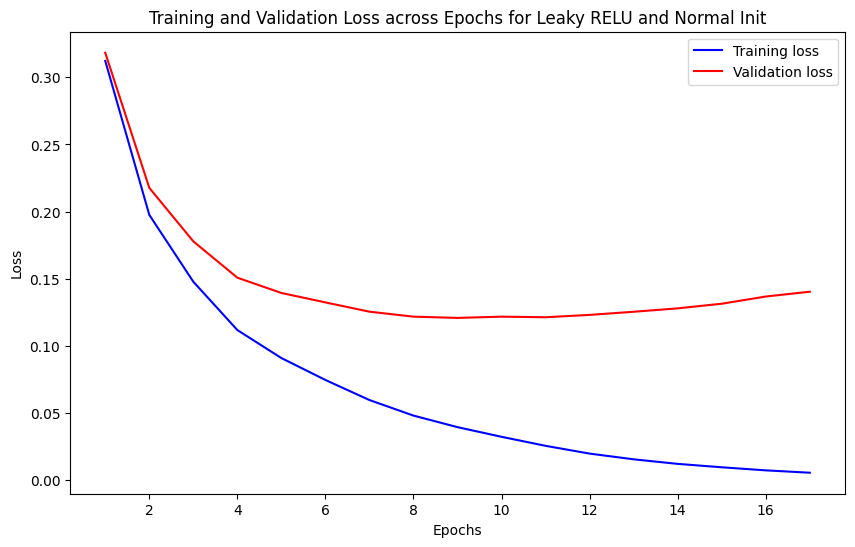

In [207]:
model = NeuralNetwork(N = 4, hidden_layer_sizes=[256,128,64,32], lr=0.1, activation_fn='leaky_relu',weight_init_fn='normal_init', 
                      n_epochs=100, batch_size=128, early_stopping=True)

model.fit(X_train, Y_train)

accuracy_dict['LeakyRELU_Normal'] = model.score(X_test, Y_test)

with open('LeakyRELU_Normal.pkl', 'wb') as file:
    pickle.dump(model, file)


n_epochs = range(1, len(model.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_epochs, model.train_losses, 'b', label='Training loss')
plt.plot(n_epochs, model.val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for Leaky RELU and Normal Init')
plt.legend()

plt.show()

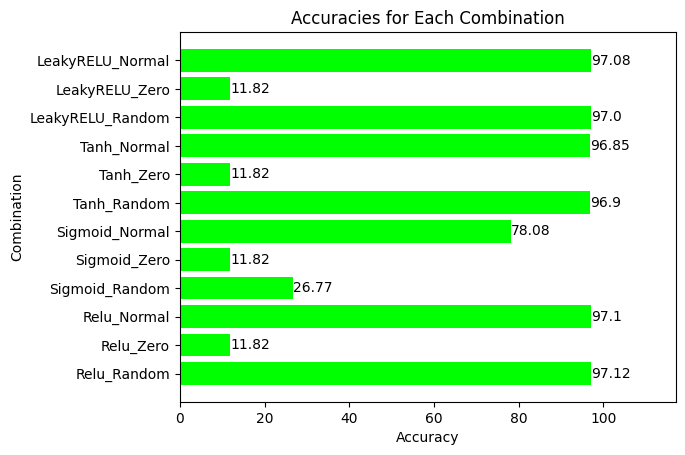

In [208]:
methods = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

# Creating the bar plot
plt.barh(methods, accuracies, color='lime')

for index, value in enumerate(accuracies):
    plt.text(value, index, str(value), ha='left', va='center')  # Adjusting positioning for horizontal bars

plt.xlabel('Accuracy')
plt.ylabel('Combination')
plt.title('Accuracies for Each Combination')

plt.xlim(0, max(accuracies) + 20)  # Extend x-axis for better visibility of the text
plt.show()

In [8]:
with open('Relu_Random.pkl', 'rb') as file:
    model = pickle.load(file)
print('Score by Relu_Random:')
model.score(X_test, Y_test)


with open('Relu_Zero.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Relu_Random:')
model.score(X_test, Y_test)


with open('Relu_Normal.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Relu_Normal:')
model.score(X_test, Y_test)


with open('Sigmoid_Random.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Sigmoid_Random:')
model.score(X_test, Y_test)


with open('Sigmoid_Zero.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Sigmoid_Zero:')
model.score(X_test, Y_test)


with open('Sigmoid_Normal.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Sigmoid_Normal:')
model.score(X_test, Y_test)


with open('Tanh_Random.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Tanh_Random:')
model.score(X_test, Y_test)


with open('Tanh_Zero.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Tanh_Zero:')
model.score(X_test, Y_test)


with open('Tanh_Normal.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by Tanh_Normal:')
model.score(X_test, Y_test)


with open('LeakyRELU_Random.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by LeakyReLU_Random:')
model.score(X_test, Y_test)


with open('LeakyRELU_Zero.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by LeakyReLU_Zero:')
model.score(X_test, Y_test)


with open('LeakyRELU_Normal.pkl', 'rb') as file:
    model = pickle.load(file)
print(f'\nScore by LeakyReLU_Normal:')
model.score(X_test, Y_test);

Score by Relu_Random:
The accuracy is 96.28%.

Score by Relu_Random:
The accuracy is 11.1%.

Score by Relu_Normal:
The accuracy is 96.6%.

Score by Sigmoid_Random:
The accuracy is 26.77%.

Score by Sigmoid_Zero:
The accuracy is 11.1%.

Score by Sigmoid_Normal:


C:\Users\Abhirup Das\AppData\Local\Temp\ipykernel_74304\1274100114.py:349: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-input)) # Sigmoid is 1 / (1 + e^(-x))


The accuracy is 77.8%.

Score by Tanh_Random:
The accuracy is 96.43%.

Score by Tanh_Zero:
The accuracy is 11.1%.

Score by Tanh_Normal:
The accuracy is 96.38%.

Score by LeakyReLU_Random:
The accuracy is 96.12%.

Score by LeakyReLU_Zero:
The accuracy is 11.1%.

Score by LeakyReLU_Normal:
The accuracy is 96.3%.
